In [1]:
import pandas as pd
import numpy as np
import pickle
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold, RepeatedStratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest

import category_encoders as ce

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE

import pingouin as pg

from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score, plot_confusion_matrix, plot_roc_curve, roc_curve, plot_precision_recall_curve, precision_recall_curve, auc

In [2]:
df_clean = pd.read_csv('churn_cleaned.csv')
df_clean

C:\Users\Anonymous\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.8, the latest is 0.3.10.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,0
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,0
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,0
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,1


In [3]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


### Feature Selection using univariate feature selection

In [4]:
x_selection = df_clean.drop('Churn',axis=1)
y_selection = df_clean['Churn']

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x_selection,y_selection,test_size=0.2,stratify=y_selection,random_state=7)

In [6]:
ordinal_mapping=[
    {'col': 'Contract',
     'mapping': {'Month-to-month': 0, 'One year': 1, 'Two year':2}}
]

ordinal_pipeline = Pipeline([
    ('ordinal',ce.OrdinalEncoder(cols = 'Contract', mapping = ordinal_mapping))
])

onehot_encoder_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop='first'))
])

median_pipeline = Pipeline([
    ('impute_median', SimpleImputer(strategy='median')),
    ('minmaxmedian', MinMaxScaler())
])

numerical_pipeline = Pipeline([
    ('minmax', MinMaxScaler())
])

transformer = ColumnTransformer([
    ('ordinal_pipe', ordinal_pipeline, ['Contract']),
    ('onehot_pipe', onehot_encoder_pipeline, ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'PaymentMethod']),
    ('median_pipe', median_pipeline, ['TotalCharges']),
    ('numerical_pipe', numerical_pipeline, ['tenure', 'MonthlyCharges'])
], remainder='passthrough')

In [7]:
x_train_preprocessed = transformer.fit_transform(x_train)
x_test_preprocessed = transformer.transform(x_test)

In [8]:
x_train_preprocessed = pd.DataFrame(x_train_preprocessed)
x_test_preprocessed = pd.DataFrame(x_test_preprocessed)
x_train_preprocessed

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.483816,0.597222,0.813433,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.375606,0.625000,0.574129,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.008626,0.069444,0.023881,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.084566,0.125000,0.622886,1.0
4,2.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.866836,0.930556,0.924876,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5629,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.497052,0.944444,0.456219,0.0
5630,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.220690,0.597222,0.257711,0.0
5631,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.497646,0.722222,0.652239,0.0
5632,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.000144,0.013889,0.017910,0.0


In [9]:
transformer.transformers_

[('ordinal_pipe',
  Pipeline(steps=[('ordinal',
                   OrdinalEncoder(cols=['Contract'],
                                  mapping=[{'col': 'Contract',
                                            'mapping': {'Month-to-month': 0,
                                                        'One year': 1,
                                                        'Two year': 2}}]))]),
  ['Contract']),
 ('onehot_pipe',
  Pipeline(steps=[('onehot', OneHotEncoder(drop='first'))]),
  ['gender',
   'Partner',
   'Dependents',
   'PhoneService',
   'MultipleLines',
   'InternetService',
   'OnlineSecurity',
   'OnlineBackup',
   'DeviceProtection',
   'TechSupport',
   'StreamingTV',
   'StreamingMovies',
   'PaperlessBilling',
   'PaymentMethod']),
 ('median_pipe',
  Pipeline(steps=[('impute_median', SimpleImputer(strategy='median')),
                  ('minmaxmedian', MinMaxScaler())]),
  ['TotalCharges']),
 ('numerical_pipe',
  Pipeline(steps=[('minmax', MinMaxScaler())]),
  ['tenure', 

In [10]:
transformer.transformers_[0][1][0].get_feature_names()

['Contract']

In [11]:
transformer.transformers_[1][1][0].get_feature_names()

array(['x0_Male', 'x1_Yes', 'x2_Yes', 'x3_Yes', 'x4_No phone service',
       'x4_Yes', 'x5_Fiber optic', 'x5_No', 'x6_No internet service',
       'x6_Yes', 'x7_No internet service', 'x7_Yes',
       'x8_No internet service', 'x8_Yes', 'x9_No internet service',
       'x9_Yes', 'x10_No internet service', 'x10_Yes',
       'x11_No internet service', 'x11_Yes', 'x12_Yes',
       'x13_Credit card (automatic)', 'x13_Electronic check',
       'x13_Mailed check'], dtype=object)

In [12]:
features = transformer.transformers_[0][1][0].get_feature_names() + list(transformer.transformers_[1][1][0].get_feature_names()) + 'TotalCharges tenure MonthlyCharges SeniorCitizen'.split()
len(features)

29

In [13]:
x_train_preprocessed.columns = features
x_test_preprocessed.columns = features
x_train_preprocessed

,Contract,x0_Male,x1_Yes,x2_Yes,x3_Yes,x4_No phone service,x4_Yes,x5_Fiber optic,x5_No,x6_No internet service,...,x11_No internet service,x11_Yes,x12_Yes,x13_Credit card (automatic),x13_Electronic check,x13_Mailed check,TotalCharges,tenure,MonthlyCharges,SeniorCitizen
0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.483816,0.597222,0.813433,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.375606,0.625000,0.574129,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.008626,0.069444,0.023881,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.084566,0.125000,0.622886,1.0
4,2.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.866836,0.930556,0.924876,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5629,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.497052,0.944444,0.456219,0.0
5630,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.220690,0.597222,0.257711,0.0
5631,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.497646,0.722222,0.652239,0.0
5632,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.000144,0.013889,0.017910,0.0


In [14]:
select = SelectKBest(k=10)
select.fit(x_train_preprocessed, y_train)

SelectKBest()

In [15]:
x_train_selected = select.transform(x_train_preprocessed)
x_test_selected = select.transform(x_test_preprocessed)

In [16]:
mask = select.get_support()
mask

array([ True, False, False, False, False, False, False,  True, False,
        True, False,  True, False,  True, False,  True, False,  True,
       False,  True, False, False, False,  True, False, False,  True,
       False, False])

In [17]:
selected_features = pd.DataFrame({
    'indicator': mask,
    'score': select.scores_,
    'features': features
})
selected_features

,indicator,score,features
0,True,1031.290121,Contract
1,False,0.012711,x0_Male
2,False,119.384386,x1_Yes
3,False,146.050308,x2_Yes
4,False,0.695325,x3_Yes
5,False,0.695325,x4_No phone service
6,False,8.649151,x4_Yes
7,True,584.695708,x5_Fiber optic
8,False,302.541051,x5_No
9,True,302.541051,x6_No internet service


### Fitur yang akan digunakan untuk prediksi adalah 'Contract', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaymentMethod', 'tenure'

In [18]:
x = df_clean.drop(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn'], axis=1)
y = df_clean['Churn']

In [19]:
x_train_val, x_test, y_train_val, y_test = train_test_split(x,y,test_size=0.2,stratify=y,random_state=7)

In [20]:
dtc = DecisionTreeClassifier(random_state=1)
knn = KNeighborsClassifier()
logit = LogisticRegression()
rf = RandomForestClassifier(random_state=3)

In [21]:
ordinal_mapping=[
    {'col': 'Contract',
     'mapping': {'Month-to-month': 0, 'One year': 1, 'Two year':2}}
]

ordinal_pipeline = Pipeline([
    ('ordinal',ce.OrdinalEncoder(cols = 'Contract', mapping = ordinal_mapping))
])

onehot_encoder_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop='first'))
])

numerical_pipeline = Pipeline([
    ('minmax', MinMaxScaler())
])

transformer = ColumnTransformer([
    ('ordinal_pipe', ordinal_pipeline, ['Contract']),
    ('onehot_pipe', onehot_encoder_pipeline, ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaymentMethod']),
    ('numerical_pipe', numerical_pipeline, ['tenure'])
], remainder='passthrough')

all_in_pipeline_dtc = Pipeline([
    ('transformer', transformer),
    ('clf', dtc)
])

all_in_pipeline_knn = Pipeline([
    ('transformer', transformer),
    ('clf', knn)
])

all_in_pipeline_logit = Pipeline([
    ('transformer', transformer),
    ('clf', logit)
])

all_in_pipeline_rf = Pipeline([
    ('transformer', transformer),
    ('clf', rf)
])

In [22]:
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=7)
n_scores_dtc = cross_val_score(all_in_pipeline_dtc, x_train_val, y_train_val, scoring='recall', cv=rskf, n_jobs=-1)
n_scores_dtc

array([0.47491639, 0.44481605, 0.44481605, 0.46488294, 0.49498328,
       0.46488294, 0.4916388 , 0.46153846, 0.52508361, 0.48494983,
       0.47491639, 0.43812709, 0.45150502, 0.46153846, 0.48160535,
       0.50501672, 0.49832776, 0.46822742, 0.52173913, 0.47826087,
       0.46822742, 0.4548495 , 0.46822742, 0.45150502, 0.48494983])

In [23]:
print(np.mean(n_scores_dtc))
print(np.std(n_scores_dtc))

0.47438127090301
0.022319096732342524


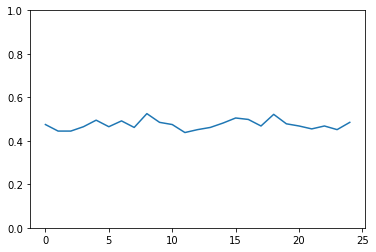

In [24]:
plt.plot(np.arange(len(n_scores_dtc)), n_scores_dtc)
plt.ylim(0,1)
plt.show()

In [25]:
n_scores_knn = cross_val_score(all_in_pipeline_knn, x_train_val, y_train_val, scoring='recall', cv=rskf, n_jobs=-1)
n_scores_knn

array([0.49498328, 0.48160535, 0.43143813, 0.4916388 , 0.52173913,
       0.47491639, 0.47157191, 0.47491639, 0.46488294, 0.53511706,
       0.48160535, 0.44481605, 0.46822742, 0.4548495 , 0.45150502,
       0.50167224, 0.50501672, 0.45819398, 0.46488294, 0.44147157,
       0.45150502, 0.48160535, 0.51505017, 0.44816054, 0.54849498])

In [26]:
print(np.mean(n_scores_knn))
print(np.std(n_scores_knn))

0.4783946488294315
0.02942353192682465


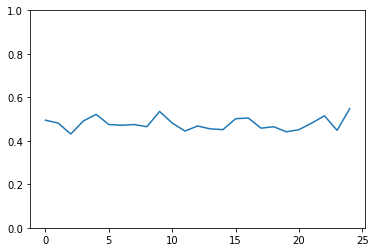

In [27]:
plt.plot(np.arange(len(n_scores_knn)), n_scores_knn)
plt.ylim(0,1)
plt.show()

In [28]:
n_scores_logit = cross_val_score(all_in_pipeline_logit, x_train_val, y_train_val, scoring='recall', cv=rskf, n_jobs=-1)
n_scores_logit

array([0.51505017, 0.5083612 , 0.52173913, 0.52173913, 0.47826087,
       0.4916388 , 0.50167224, 0.51505017, 0.48494983, 0.55183946,
       0.50501672, 0.4916388 , 0.54180602, 0.5083612 , 0.5083612 ,
       0.55518395, 0.52173913, 0.52842809, 0.47157191, 0.52842809,
       0.51839465, 0.52173913, 0.54180602, 0.48494983, 0.48494983])

In [29]:
print(np.mean(n_scores_logit))
print(np.std(n_scores_logit))

0.5121070234113713
0.022090193402425157


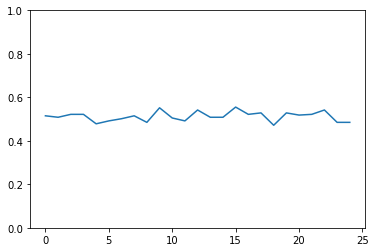

In [30]:
plt.plot(np.arange(len(n_scores_logit)), n_scores_logit)
plt.ylim(0,1)
plt.show()

In [31]:
n_scores_rf = cross_val_score(all_in_pipeline_rf, x_train_val, y_train_val, scoring='recall', cv=rskf, n_jobs=-1)
n_scores_rf

array([0.50167224, 0.45150502, 0.47826087, 0.48494983, 0.55183946,
       0.49498328, 0.45819398, 0.49498328, 0.5083612 , 0.51505017,
       0.51170569, 0.46488294, 0.49498328, 0.50167224, 0.48494983,
       0.5083612 , 0.48829431, 0.46488294, 0.4916388 , 0.44816054,
       0.46488294, 0.49832776, 0.51505017, 0.45150502, 0.4916388 ])

In [32]:
print(np.mean(n_scores_rf))
print(np.std(n_scores_rf))

0.4888294314381271
0.02401850123749878


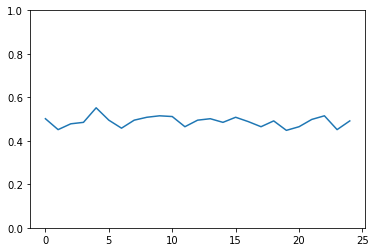

In [33]:
plt.plot(np.arange(len(n_scores_rf)), n_scores_rf)
plt.ylim(0,1)
plt.show()

In [34]:
dtc = DecisionTreeClassifier(random_state=1, class_weight='balanced')
knn = KNeighborsClassifier()
logit = LogisticRegression(class_weight='balanced')
rf = RandomForestClassifier(random_state=3)

smote = SMOTE(random_state=24)
over = RandomOverSampler(random_state=24)

all_in_pipeline_dtc_performance = Pipeline([
    ('transformer', transformer),
    ('clf', dtc)
])

all_in_pipeline_knn_performance = Pipeline([
    ('transformer', transformer),
    ('resampling', smote),
    ('clf', knn)
])

all_in_pipeline_logit_performance = Pipeline([
    ('transformer', transformer),
    ('clf', logit)
])

all_in_pipeline_rf_performance = Pipeline([
    ('transformer', transformer),
    ('resampling', over),
    ('clf', rf)
])

In [35]:
hyperparam_space_dtc = {
    'clf__max_depth': [10,30,50,70,90,100],
    'clf__min_samples_split': [10,30,50,70,90,100],
    'clf__min_samples_leaf': [10,30,50,70,90,100],
    'clf__criterion': ['entropy', 'gini']}

skf = StratifiedKFold(n_splits=5)

gridsearch_dtc = GridSearchCV(all_in_pipeline_dtc_performance, hyperparam_space_dtc, scoring='recall', n_jobs=-1, cv=skf)
gridsearch_dtc.fit(x_train_val, y_train_val)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinal_pipe',
                                                                         Pipeline(steps=[('ordinal',
                                                                                          OrdinalEncoder(cols='Contract',
                                                                                                         mapping=[{'col': 'Contract',
                                                                                                                   'mapping': {'Month-to-month': 0,
                                                                                                                               'One year': 1,
                                               

In [36]:
cv_res_dtc = pd.DataFrame(gridsearch_dtc.cv_results_)
cv_res_dtc.sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__criterion,param_clf__max_depth,param_clf__min_samples_leaf,param_clf__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
227,0.123270,0.017212,0.037300,0.016624,gini,10,30,100,"{'clf__criterion': 'gini', 'clf__max_depth': 1...",0.816054,0.779264,0.816054,0.792642,0.852843,0.811371,0.025081,1
335,0.128658,0.019217,0.038096,0.016468,gini,70,30,100,"{'clf__criterion': 'gini', 'clf__max_depth': 7...",0.816054,0.779264,0.816054,0.792642,0.852843,0.811371,0.025081,1
371,0.146209,0.006389,0.035505,0.022199,gini,90,30,100,"{'clf__criterion': 'gini', 'clf__max_depth': 9...",0.816054,0.779264,0.816054,0.792642,0.852843,0.811371,0.025081,1
263,0.113496,0.019063,0.030120,0.016124,gini,30,30,100,"{'clf__criterion': 'gini', 'clf__max_depth': 3...",0.816054,0.779264,0.816054,0.792642,0.852843,0.811371,0.025081,1
407,0.123070,0.018929,0.029920,0.015895,gini,100,30,100,"{'clf__criterion': 'gini', 'clf__max_depth': 1...",0.816054,0.779264,0.816054,0.792642,0.852843,0.811371,0.025081,1


In [37]:
hyperparam_space_knn = {
    'clf__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'clf__leaf_size': [10,20,30,40,50,60],
    'clf__n_neighbors': [3,5,7,9,11],
    'clf__weights': ['uniform','distance'],
    'clf__metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']}

skf = StratifiedKFold(n_splits=5)

gridsearch_knn = GridSearchCV(all_in_pipeline_knn_performance, hyperparam_space_knn, scoring='recall', n_jobs=-1, cv=skf)
gridsearch_knn.fit(x_train_val, y_train_val)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinal_pipe',
                                                                         Pipeline(steps=[('ordinal',
                                                                                          OrdinalEncoder(cols='Contract',
                                                                                                         mapping=[{'col': 'Contract',
                                                                                                                   'mapping': {'Month-to-month': 0,
                                                                                                                               'One year': 1,
                                               

In [38]:
cv_res_knn = pd.DataFrame(gridsearch_knn.cv_results_)
cv_res_knn.sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__algorithm,param_clf__leaf_size,param_clf__metric,param_clf__n_neighbors,param_clf__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
228,0.284439,0.013637,0.435635,0.009595,auto,60,chebyshev,11,uniform,"{'clf__algorithm': 'auto', 'clf__leaf_size': 6...",0.836120,0.826087,0.77592,0.742475,0.809365,0.797993,0.034473,1
468,0.224001,0.017189,0.384572,0.018440,ball_tree,60,chebyshev,11,uniform,"{'clf__algorithm': 'ball_tree', 'clf__leaf_siz...",0.836120,0.826087,0.77592,0.742475,0.809365,0.797993,0.034473,1
708,0.231779,0.011382,0.352059,0.012182,kd_tree,60,chebyshev,11,uniform,"{'clf__algorithm': 'kd_tree', 'clf__leaf_size'...",0.836120,0.826087,0.77592,0.742475,0.809365,0.797993,0.034473,1
388,0.215424,0.003338,0.381780,0.008611,ball_tree,40,chebyshev,11,uniform,"{'clf__algorithm': 'ball_tree', 'clf__leaf_siz...",0.829431,0.799331,0.77592,0.765886,0.806020,0.795318,0.022525,4
428,0.211035,0.005147,0.379984,0.018270,ball_tree,50,chebyshev,11,uniform,"{'clf__algorithm': 'ball_tree', 'clf__leaf_siz...",0.829431,0.799331,0.77592,0.765886,0.806020,0.795318,0.022525,4


In [39]:
hyperparam_space_logit = {
    'clf__max_iter': [50, 100, 150],
    'clf__multi_class': ['auto', 'ovr', 'multinomial'],
    'clf__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

skf = StratifiedKFold(n_splits=5)

gridsearch_logit = GridSearchCV(all_in_pipeline_logit_performance, hyperparam_space_logit, scoring='recall', n_jobs=-1, cv=skf)
gridsearch_logit.fit(x_train_val, y_train_val)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinal_pipe',
                                                                         Pipeline(steps=[('ordinal',
                                                                                          OrdinalEncoder(cols='Contract',
                                                                                                         mapping=[{'col': 'Contract',
                                                                                                                   'mapping': {'Month-to-month': 0,
                                                                                                                               'One year': 1,
                                               

In [40]:
cv_res_logit = pd.DataFrame(gridsearch_logit.cv_results_)
cv_res_logit.sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__max_iter,param_clf__multi_class,param_clf__penalty,param_clf__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
89,0.101329,0.004487,0.018950,0.001784,100,ovr,l2,saga,"{'clf__max_iter': 100, 'clf__multi_class': 'ov...",0.802676,0.769231,0.779264,0.80602,0.819398,0.795318,0.018367,1
28,0.131846,0.006193,0.021942,0.004505,50,ovr,l2,sag,"{'clf__max_iter': 50, 'clf__multi_class': 'ovr...",0.802676,0.769231,0.779264,0.80602,0.819398,0.795318,0.018367,1
29,0.102725,0.003277,0.021343,0.002491,50,ovr,l2,saga,"{'clf__max_iter': 50, 'clf__multi_class': 'ovr...",0.802676,0.769231,0.779264,0.80602,0.819398,0.795318,0.018367,1
145,0.094349,0.006037,0.018749,0.000747,150,ovr,l2,newton-cg,"{'clf__max_iter': 150, 'clf__multi_class': 'ov...",0.802676,0.769231,0.779264,0.80602,0.819398,0.795318,0.018367,1
146,0.070811,0.003025,0.019747,0.003590,150,ovr,l2,lbfgs,"{'clf__max_iter': 150, 'clf__multi_class': 'ov...",0.802676,0.769231,0.779264,0.80602,0.819398,0.795318,0.018367,1


In [41]:
hyperparam_space_rf = {
    'clf__max_depth': [10,30,50,70,90,100],
    'clf__min_samples_split': [10,30,50,70,90,100],
    'clf__min_samples_leaf': [10,30,50,70,90,100],
    'clf__criterion': ['entropy', 'gini'],
    'clf__n_estimators': [50,100,150]}

skf = StratifiedKFold(n_splits=5)

gridsearch_rf = GridSearchCV(all_in_pipeline_rf_performance, hyperparam_space_rf, scoring='recall', n_jobs=-1, cv=skf)
gridsearch_rf.fit(x_train_val, y_train_val)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinal_pipe',
                                                                         Pipeline(steps=[('ordinal',
                                                                                          OrdinalEncoder(cols='Contract',
                                                                                                         mapping=[{'col': 'Contract',
                                                                                                                   'mapping': {'Month-to-month': 0,
                                                                                                                               'One year': 1,
                                               

In [42]:
cv_res_rf = pd.DataFrame(gridsearch_rf.cv_results_)
cv_res_rf.sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__criterion,param_clf__max_depth,param_clf__min_samples_leaf,param_clf__min_samples_split,param_clf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
702,0.325729,0.006663,0.034906,0.001784,gini,10,70,10,50,"{'clf__criterion': 'gini', 'clf__max_depth': 1...",0.826087,0.77592,0.799331,0.842809,0.83612,0.816054,0.024938,1
717,0.329719,0.005937,0.033909,0.001411,gini,10,70,100,50,"{'clf__criterion': 'gini', 'clf__max_depth': 1...",0.826087,0.77592,0.799331,0.842809,0.83612,0.816054,0.024938,1
714,0.329519,0.002999,0.033511,0.001197,gini,10,70,90,50,"{'clf__criterion': 'gini', 'clf__max_depth': 1...",0.826087,0.77592,0.799331,0.842809,0.83612,0.816054,0.024938,1
705,0.323335,0.005863,0.035904,0.004636,gini,10,70,30,50,"{'clf__criterion': 'gini', 'clf__max_depth': 1...",0.826087,0.77592,0.799331,0.842809,0.83612,0.816054,0.024938,1
711,0.328122,0.007330,0.036502,0.002863,gini,10,70,70,50,"{'clf__criterion': 'gini', 'clf__max_depth': 1...",0.826087,0.77592,0.799331,0.842809,0.83612,0.816054,0.024938,1


In [43]:
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=7)
rf_tuned = gridsearch_rf.best_estimator_
rf_tuned_score = cross_val_score(rf_tuned, x_train_val, y_train_val, scoring='recall', cv=rskf, n_jobs=-1)
rf_tuned_score

array([0.77257525, 0.80936455, 0.7993311 , 0.80602007, 0.78595318,
       0.77591973, 0.7993311 , 0.81270903, 0.7826087 , 0.79598662,
       0.80602007, 0.81939799, 0.82608696, 0.76923077, 0.78929766,
       0.80602007, 0.83277592, 0.81939799, 0.77591973, 0.76588629,
       0.80267559, 0.80936455, 0.82943144, 0.80602007, 0.7993311 ])

In [44]:
print(np.mean(rf_tuned_score))
print(np.std(rf_tuned_score))

0.7998662207357862
0.018456690750281505


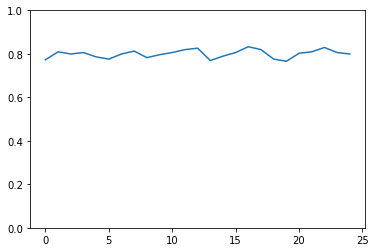

In [45]:
plt.plot(np.arange(len(rf_tuned_score)), rf_tuned_score)
plt.ylim(0,1)
plt.show()

In [46]:
model_rf = gridsearch_rf.best_estimator_.fit(x_train_val, y_train_val)
y_pred_tuned_rf = model_rf.predict(x_test)

In [47]:
print(classification_report(y_test, y_pred_tuned_rf))

              precision    recall  f1-score   support

           0       0.92      0.73      0.82      1035
           1       0.53      0.82      0.64       374

    accuracy                           0.76      1409
   macro avg       0.72      0.78      0.73      1409
weighted avg       0.82      0.76      0.77      1409



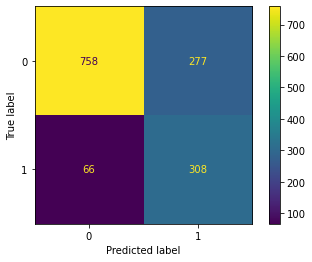

In [48]:
plot_confusion_matrix(model_rf, x_test, y_test)

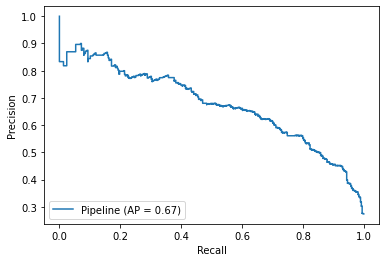

In [49]:
plot_precision_recall_curve(model_rf, x_test, y_test)

In [50]:
p, r, t = precision_recall_curve(y_test, model_rf.predict_proba(x_test)[:,1])
prt_df = pd.DataFrame({'precision': p[:-1], 'recall': r[:-1], 'threshold': t})
prt_df

,precision,recall,threshold
0,0.274194,1.000000,0.017248
1,0.274669,0.997326,0.017881
2,0.275888,0.997326,0.018086
3,0.276092,0.997326,0.018106
4,0.276501,0.997326,0.019623
...,...,...,...
1032,0.900000,0.072193,0.876641
1033,0.896552,0.069519,0.884778
1034,0.869565,0.053476,0.887104
1035,0.818182,0.024064,0.888483


In [51]:
prt_df[(prt_df['recall'].between(0.8, 0.86))].head(30)

,precision,recall,threshold
533,0.488584,0.858289,0.455409
534,0.489329,0.858289,0.456060
535,0.490076,0.858289,0.457487
536,0.490826,0.858289,0.457732
537,0.491577,0.858289,0.457796
538,0.492331,0.858289,0.458880
539,0.493088,0.858289,0.460343
540,0.493846,0.858289,0.461247
541,0.494607,0.858289,0.461903
542,0.495370,0.858289,0.463846


In [52]:
thr_move_to = 0.472842
y_pred_thr04 = np.where(model_rf.predict_proba(x_test)[:,1] > thr_move_to, 1, 0)
print(classification_report(y_test, y_pred_thr04))

              precision    recall  f1-score   support

           0       0.93      0.69      0.79      1035
           1       0.50      0.85      0.63       374

    accuracy                           0.74      1409
   macro avg       0.71      0.77      0.71      1409
weighted avg       0.81      0.74      0.75      1409



In [53]:
model_rf.fit(x,y)
filename = 'rf_final.sav'
pickle.dump(model_rf, open(filename, 'wb'))